# Initializations

## imports

In [1]:
from torchvision.datasets import MNIST
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torchvision
from torch.autograd import Variable

import seaborn as sns
import numpy as np

## configs

In [2]:
batch_size_train = 128
batch_size_test = 100
random_seed = 12453211

imbalanced_weights = {
    0: 0.3,
    1: 0.3,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 0.3,
    6: 1.0,
    7: 0.3,
    8: 1.0,
    9: 1.0
}

#2 → 7, 3 → 8, 5 ↔ 6 and 7 → 1 from SL paper
# Creating asymettric noise for 0,3,4 and 8
asymmetric_noise = {
    0: 0,
    1: 1,
    2: 7,
    3: 8,
    4: 4,
    5: 6,
    6: 5,
    7: 1,
    8: 8,
    9: 9
}

torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Data Preparation

## Loading torch dataset

In [3]:

train_set = torchvision.datasets.MNIST(
    '.',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_set = torchvision.datasets.MNIST(
    '.',
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size_test,
    shuffle=False
)

## loading numpy dataset

In [4]:
def data_loader_to_numpy(data_loader):
    result_x = []
    result_y = []
    for x, y in data_loader:
        result_x.append(x.numpy())
        result_y.append(y.numpy())
        
    return np.concatenate(result_x, axis=0), np.concatenate(result_y, axis=0)
    
train_x, train_y = data_loader_to_numpy(train_loader)
test_x, test_y = data_loader_to_numpy(test_loader)
valid_x, valid_y = data_loader_to_numpy(valid_loader)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(50000, 1, 28, 28) (10000, 1, 28, 28) (50000,) (10000,)


## distribution of classes

<AxesSubplot:ylabel='Count'>

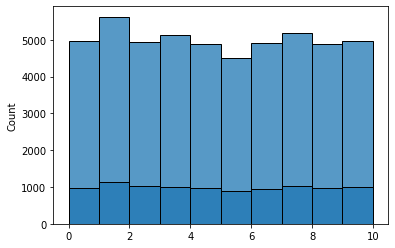

In [5]:
sns.histplot(train_y, bins=[i for i in range(11)])
sns.histplot(test_y, bins=[i for i in range(11)])

In [6]:
train_classes = [label for _, label in train_set]
data_count = Counter(train_classes)
print(mode,data_count)
palette = sns.color_palette("husl")
sns.barplot(x=list(data_count.keys()),y=list(data_count.values()),palette=palette)

NameError: name 'Counter' is not defined

In [ ]:
for index, (images,labels) in enumerate(train_loader):
    if index % 10 == 0:
        print(labels[1])
        plt.imshow(images[1].reshape(28,28), cmap="gray")
        plt.show()

## Creating imbalanced dataset

In [9]:
def make_imbalanced(ds_x, ds_y, imbalanced_weights=imbalanced_weights):
    class_partition = {k:[] for k in range(10)}

    for x, y in zip(ds_x, ds_y):
        class_partition[y].append((x, y))

    for i in range(10):
        idxs = np.random.randint(0, len(class_partition[i]), int(imbalanced_weights[i]*len(class_partition[i])))
        class_partition[i] = [class_partition[i][j] for j in idxs]
        print(f"class {i}: size={len(class_partition[i])}")

    imbalanced_train = []

    for partition in class_partition.values():
        imbalanced_train.extend(partition)

    np.random.shuffle(imbalanced_train)
    imbalanced_train_x, imbalanced_train_y = zip(*imbalanced_train)
    
    return imbalanced_train_x, imbalanced_train_y

imb_train_x, imb_train_y = make_imbalanced(train_x, train_y)

class 0: size=1488
class 1: size=1688
class 2: size=4942
class 3: size=5132
class 4: size=4894
class 5: size=1350
class 6: size=4908
class 7: size=1554
class 8: size=4891
class 9: size=4960


In [ ]:
sns.histplot(imb_train_y, bins=[i for i in range(11)])

## create a dataset with symmetric noise

In [29]:
def apply_sym_noise(ds_x, ds_y, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(np.random.randint(10))
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_sym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

## create a dataset with asymmetric noise

In [30]:
def apply_asym_noise(ds_x, ds_y, asym_noise_map=asymmetric_noise):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        noisy_labels.append(asym_noise_map[y])

    return ds_x, np.array(noisy_labels)

x, y = apply_sym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

# Generating All datasets

In [31]:
from torch.utils.data import TensorDataset

def generate_data_loader_from_np(_x, _y, batch_size_train=batch_size_train, valid_frac=0.1):
    tensor_x, tensor_y = torch.Tensor(np.array(_x)), torch.Tensor(np.array(_y))
    train_set = TensorDataset(tensor_x, tensor_y)
    
    valid_size = int(len(train_set)*valid_frac)
    train_size = len(train_set) - valid_size
    
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size_train,
        shuffle=True
    )

    valid_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size_train,
        shuffle=True,
    )
    
    return train_loader, valid_loader


imb_train_loader, imb_valid_loader = generate_data_loader_from_np(imb_train_x, imb_train_y)


In [32]:
#balanced: train_x, train_y
#imbalanced: imb_train_x, imb_train_y
bal_sym_train_x, bal_sym_train_y = apply_sym_noise(train_x, train_y)
bal_asym_train_x, bal_asym_train_y = apply_sym_noise(train_x, train_y)
imb_sym_train_x, imb_sym_train_y = apply_sym_noise(imb_train_x, imb_train_y)
imb_asym_train_x, imb_asym_train_y = apply_sym_noise(imb_train_x, imb_train_y)

#balanced: train_loader
#imbalanced: imb_train_loader
bal_sym_train_loader, bal_sym_valid_loader = generate_data_loader_from_np(bal_sym_train_x, bal_sym_train_y)
bal_asym_train_loader, bal_asym_valid_loader = generate_data_loader_from_np(bal_asym_train_x, bal_asym_train_y)
imb_sym_train_loader, imb_sym_valid_loader = generate_data_loader_from_np(imb_sym_train_x, imb_sym_train_y)
imb_asym_train_loader, imb_asym_valid_loader = generate_data_loader_from_np(imb_asym_train_x, imb_asym_train_y)

# Models

## validation functions

### draw confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True)



In [ ]:
from sklearn.metrics import classification_report

def clf_metrics(y_true, y_pred, n_class=10):
    class_names = [str(i) for i in range(n_class)]
    print(classification_report(y_true, y_pred))
    


## SVM

### preprocessing data

In [ ]:
def preprocess(x, y):
    x, y = x.squeeze(), y
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

### model definition

In [ ]:
svm = SVC(
    kernel='linear',
    decision_function_shape='ovr',
    random_state=random_seed,
    verbose=True,
) 

svm.fit(train_x, train_y)
y_pred = svm.predict(test_x)

In [ ]:
svm.coef_.shape

In [ ]:
conf_mat(test_y, y_pred)

### model report

In [ ]:
clf_metrics(test_y, y_pred)

# Logistic Regression

## Model definition

In [ ]:
input_features = train_x[0].shape[1]
output_features = 10
num_epochs = 1

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_input_features, output_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_input_features, output_features)

    def forward(self, x):
        y_predicted = self.linear(x)
        return y_predicted


model = LogisticRegression(input_features * input_features, output_features)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## Training the logistic regression model


In [ ]:
iter = 5

for epoch in range(num_epochs):
    for batch_number, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_features *
                             input_features).requires_grad_()
        labels = labels
         # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
         # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        batch_number += 1

## Testing the logistic regression model

In [ ]:
predictions = []
real_classes = []

for images, labels in test_loader:
    # Load images to a Torch Variable
    images = images.view(-1, 28*28).requires_grad_()

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.tolist()
    labels = labels.tolist()
    predictions.append(predicted)
    real_classes.append(labels)

predictions = [item for sublist in predictions for item in sublist]
real_classes = [item for sublist in real_classes for item in sublist]

## Confusion matrix and predictions for Logistic regression

In [ ]:
conf_mat(real_classes,predictions)
clf_metrics(real_classes,predictions)

## Saving the model

In [ ]:
torch.save(model.state_dict(), 'models/logistic.pkl')

# LDAM

## define components

In [33]:
from resnet import resnet20, resnet32
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F


class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        #m_list = torch.cuda.FloatTensor(m_list)
        m_list = torch.tensor(m_list, dtype=torch.float)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        #index_float = index.type(torch.cuda.FloatTensor)
        index_float = torch.tensor(index, dtype=torch.float)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

    
cls_num_list = [5000*i for i in imbalanced_weights.values()]
print(cls_num_list)
learning_rate = 1e-4
model = resnet32()
criterion = LDAMLoss(cls_num_list)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

[1500.0, 1500.0, 5000.0, 5000.0, 5000.0, 1500.0, 5000.0, 1500.0, 5000.0, 5000.0]


## training 

In [34]:
def train_ldam(model, criterion, optimizer, train_loader, valid_loader, num_epochs, verbose=0):
    
    for epoch in range(1, num_epochs+1):
        
        epoch_losses = []
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
           
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        print(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO:
            #using validation set
            pass
        
           
train_ldam(model, criterion, optimizer, train_loader, valid_loader, num_epochs=100)


0it [00:00, ?it/s]/var/folders/c4/gdhzr5rd3q584gh9ycv3hc080000gn/T/ipykernel_14816/2249593691.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_float = torch.tensor(index, dtype=torch.float)
0it [00:01, ?it/s]


epoch 1, training loss: 140.88623046875


0it [00:01, ?it/s]


epoch 2, training loss: 143.68772888183594


0it [00:01, ?it/s]


epoch 3, training loss: 143.5650634765625


0it [00:01, ?it/s]


epoch 4, training loss: 139.25648498535156


0it [00:01, ?it/s]


epoch 5, training loss: 142.3328857421875


0it [00:01, ?it/s]


epoch 6, training loss: 132.87786865234375


0it [00:01, ?it/s]


epoch 7, training loss: 132.86180114746094


0it [00:01, ?it/s]


epoch 8, training loss: 123.68201446533203


0it [00:01, ?it/s]


epoch 9, training loss: 114.91925048828125


0it [00:01, ?it/s]


epoch 10, training loss: 132.8851776123047


0it [00:01, ?it/s]


epoch 11, training loss: 116.6919937133789


0it [00:01, ?it/s]


epoch 12, training loss: 105.71449279785156


0it [00:01, ?it/s]


epoch 13, training loss: 123.2152099609375


0it [00:00, ?it/s]


KeyboardInterrupt: 